In [ ]:
import zipfile
import os

# Specify the path to your ZIP file
zip_file_path = '/content/drive/MyDrive/Deep Learning DataSets/PetImages.zip'  # Replace with your actual ZIP file name

# Check if the ZIP file exists
if os.path.exists(zip_file_path):
    # Extract the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('extracted_data')  # Folder where the content will be extracted

    print(f"Extraction complete. Files extracted to 'extracted_data/'")
else:
    print(f"File '{zip_file_path}' not found. Please make sure the ZIP file is in the current directory.")


Extraction complete. Files extracted to 'extracted_data/'


#**Imports**

In [127]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import cv2 as cv2

from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#**Data Preprocessing**

In [128]:
#Define data path
CAT_DIR = '/content/extracted_data/PetImages/Cat'
DOG_DIR = '/content/extracted_data/PetImages/Dog'

In [129]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('/content/extracted_data/PetImages/Dog'))
n_cats = len(os.listdir('/content/extracted_data/PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

#####**The data is perfectly balanced**


#**Create Directories for Training and Validation**

In [130]:
import os

# List of directories to create
directories = [
    '/tmp/cats-v-dogs',
    '/tmp/cats-v-dogs/training',
    '/tmp/cats-v-dogs/validation',
    '/tmp/cats-v-dogs/test',
    '/tmp/cats-v-dogs/training/cats',
    '/tmp/cats-v-dogs/training/dogs',
    '/tmp/cats-v-dogs/validation/cats',
    '/tmp/cats-v-dogs/validation/dogs',
    '/tmp/cats-v-dogs/test/cats',
    '/tmp/cats-v-dogs/test/dogs'
]

# Attempt to create each directory
for directory in directories:
    try:
        # Check if the directory already exists
        if not os.path.exists(directory):
            os.mkdir(directory)
            print(f"Directory created: {directory}")
        else:
            print(f"Directory already exists: {directory}")
    except OSError as e:
        print(f"Error: Failed to create directory {directory}. {e}")

Directory already exists: /tmp/cats-v-dogs
Directory already exists: /tmp/cats-v-dogs/training
Directory already exists: /tmp/cats-v-dogs/validation
Directory already exists: /tmp/cats-v-dogs/test
Directory already exists: /tmp/cats-v-dogs/training/cats
Directory already exists: /tmp/cats-v-dogs/training/dogs
Directory already exists: /tmp/cats-v-dogs/validation/cats
Directory already exists: /tmp/cats-v-dogs/validation/dogs
Directory already exists: /tmp/cats-v-dogs/test/cats
Directory already exists: /tmp/cats-v-dogs/test/dogs


In [131]:
#Define data path
CAT_DIR = '/content/extracted_data/PetImages/Cat'
DOG_DIR = '/content/extracted_data/PetImages/Dog'

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [132]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

12489
12476
2351
2349
1217
1213


####**Now let's create a function to split the data**

In [133]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

###**Now Let's Call The Function To Create The Training/Validation Data**

In [134]:
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats', '/tmp/cats-v-dogs/test/cats',INCLUDE_TEST, 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs','/tmp/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.9)

Split sucessful!
Split sucessful!


###**As a Sanity Check Let's Check The Data Directories**

In [135]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))


print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

12499
12498
2859
2857
1785
1764


#**Create Generators**

In [136]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)


In [137]:
train_generator = train_gen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 24995 images belonging to 2 classes.
Found 5716 images belonging to 2 classes.
Found 5716 images belonging to 2 classes.


###**Now Let's Make Sure We Got The Correct Data**

In [140]:
import matplotlib.pyplot as plt

class_names = ['Cat', 'Dog']

def plot_data(generator, n_images):
    """
    Plots random data from the dataset.

    Args:
    generator: a generator instance (like train_generator, validation_generator, or test_generator)
    n_images : number of images to plot
    """
    # Get a batch of images and labels using next()
    images, labels = next(generator)
    labels = labels.astype('int32')

    # Plotting the images
    plt.figure(figsize=(14, 15))

    for i in range(n_images):
        plt.subplot(4, 3, i + 1)  # Adjust the grid size (e.g., 4 rows x 3 columns)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
        if i + 1 == n_images:
            break

    plt.show()


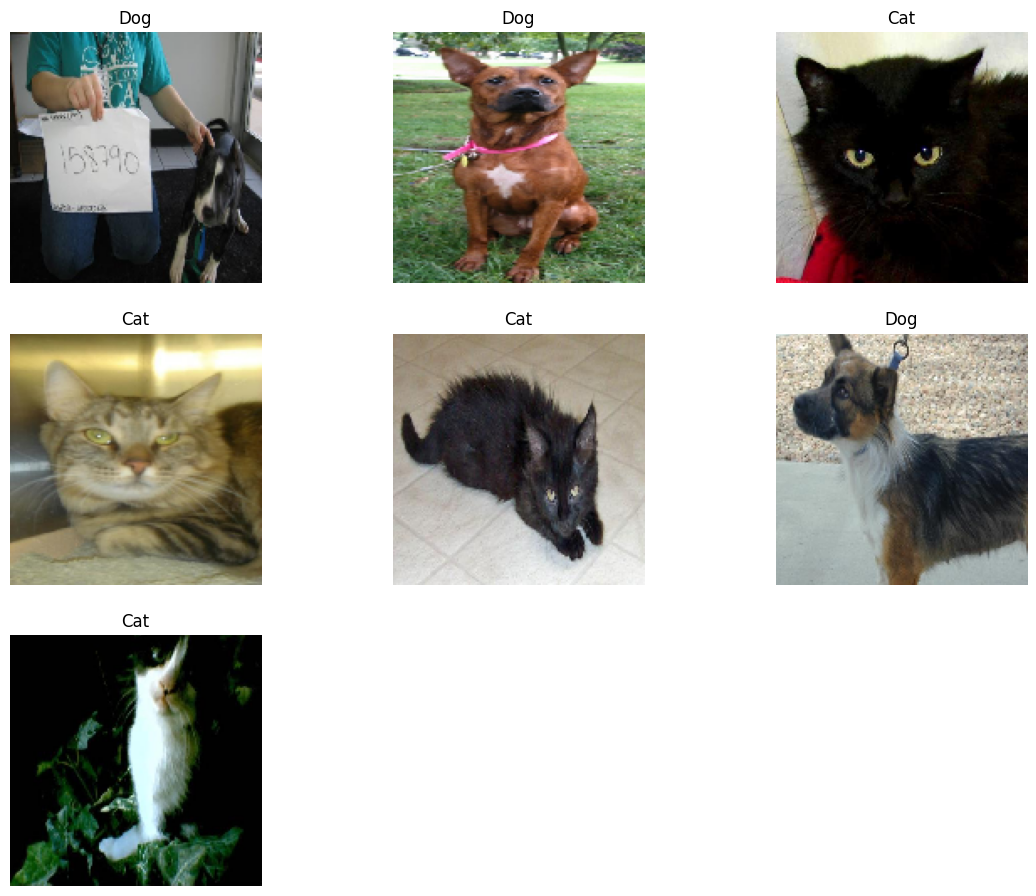

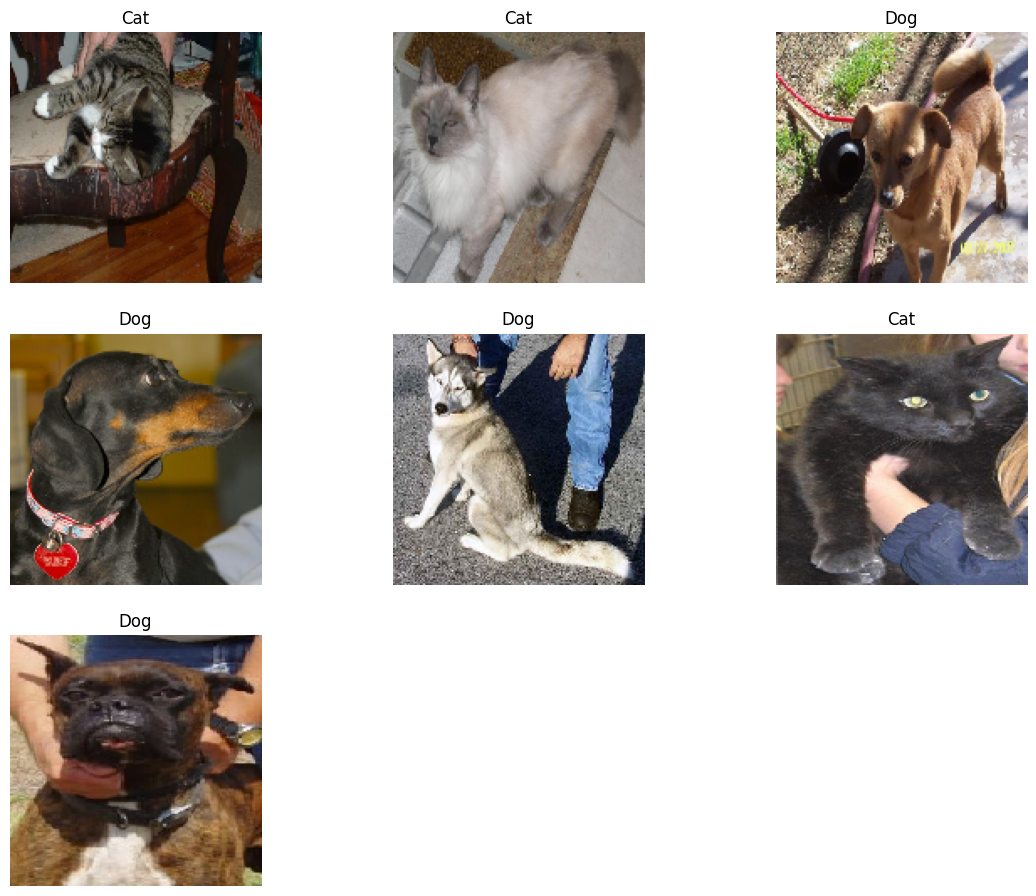

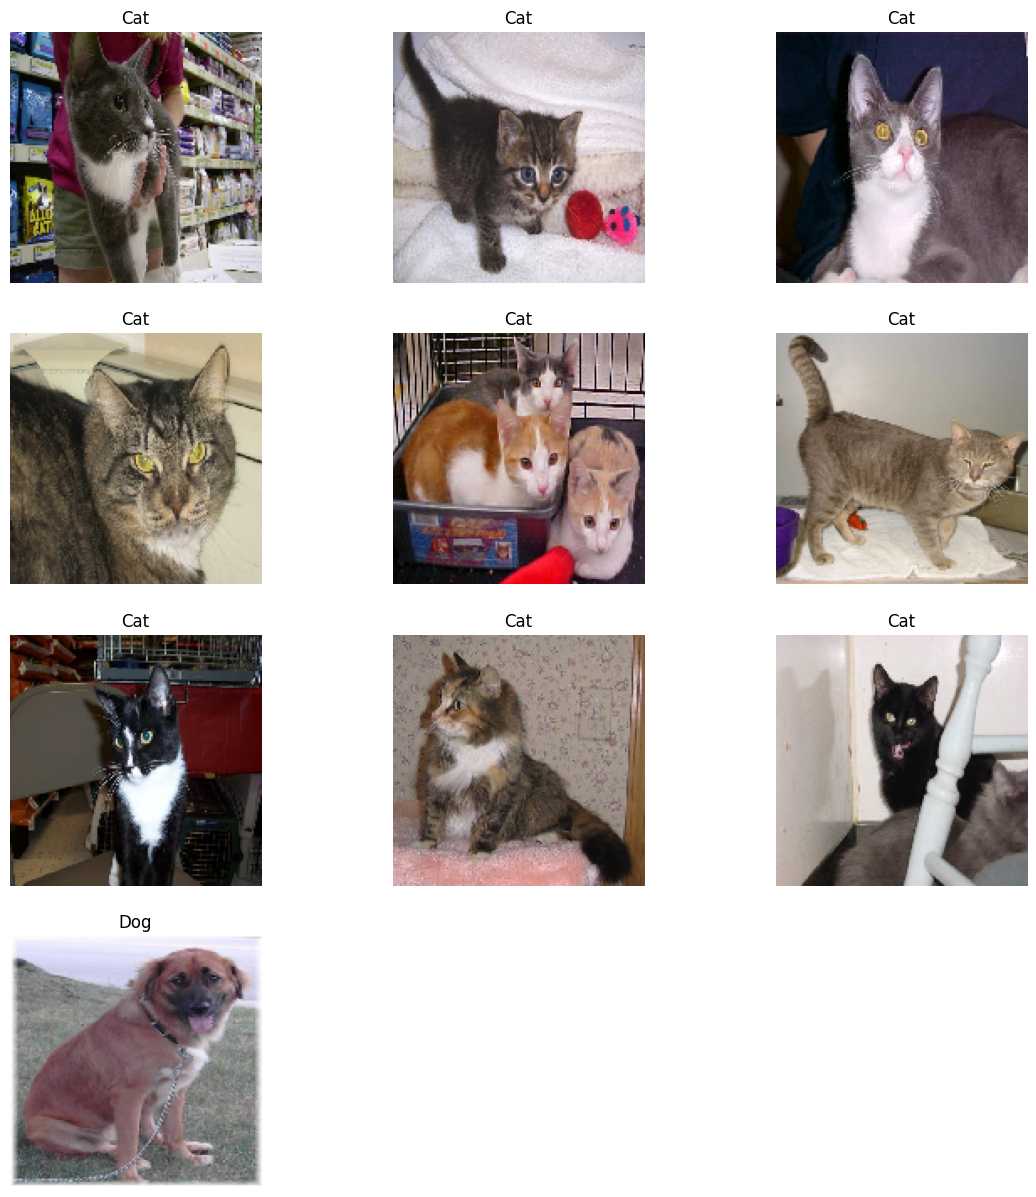

In [141]:
plot_data(train_generator, 7)
plot_data(validation_generator, 7)
if INCLUDE_TEST:
    plot_data(test_generator, 10)


#**Model**


In [142]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

In [143]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [46]:

r = model.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



329/387 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.5220 - loss: 0.6923

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning:

Truncated File Read



387/387 ━━━━━━━━━━━━━━━━━━━━ 86s 211ms/step - accuracy: 0.5262 - loss: 0.6911 - val_accuracy: 0.5824 - val_loss: 0.6631
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 69s 176ms/step - accuracy: 0.6223 - loss: 0.6479 - val_accuracy: 0.6806 - val_loss: 0.5995
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 81s 173ms/step - accuracy: 0.6724 - loss: 0.6120 - val_accuracy: 0.7074 - val_loss: 0.5623
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 83s 176ms/step - accuracy: 0.6960 - loss: 0.5847 - val_accuracy: 0.7193 - val_loss: 0.5490
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 69s 177ms/step - accuracy: 0.7114 - loss: 0.5631 - val_accuracy: 0.7320 - val_loss: 0.5374
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - accuracy: 0.7245 - loss: 0.5476 - val_accuracy: 0.6979 - val_loss: 0.5697
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 70s 178ms/step - accuracy: 0.7346 - loss: 0.5344 - val_accuracy: 0.7608 - val_loss: 0.4950
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 69s 176ms/step - accuracy: 0.7545 - loss: 0.5089 - val

#**Evaluation**

#####**Evaluate the model on the test set**

In [47]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.8163 - loss: 0.4185


###**Visualize the predicitons**

In [50]:
import matplotlib.pyplot as plt

def plot_prediction(generator, n_images):
    """
    Plots the predictions of the model along with the actual labels.

    Args:
    generator: a generator instance (like test_generator)
    n_images : number of images to plot
    """
    # Get the images and the labels from the generator
    images, labels = next(generator)

    # Get the model predictions
    preds = model.predict(images)

    # Convert labels and predictions to class indices
    labels = labels.astype('int32')
    predicted_classes = preds.argmax(axis=-1)

    plt.figure(figsize=(14, 15))

    for i in range(n_images):
        plt.subplot(4, 3, i + 1)  # Adjust the grid size as needed
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis('off')
        if i + 1 == n_images:
            break

    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


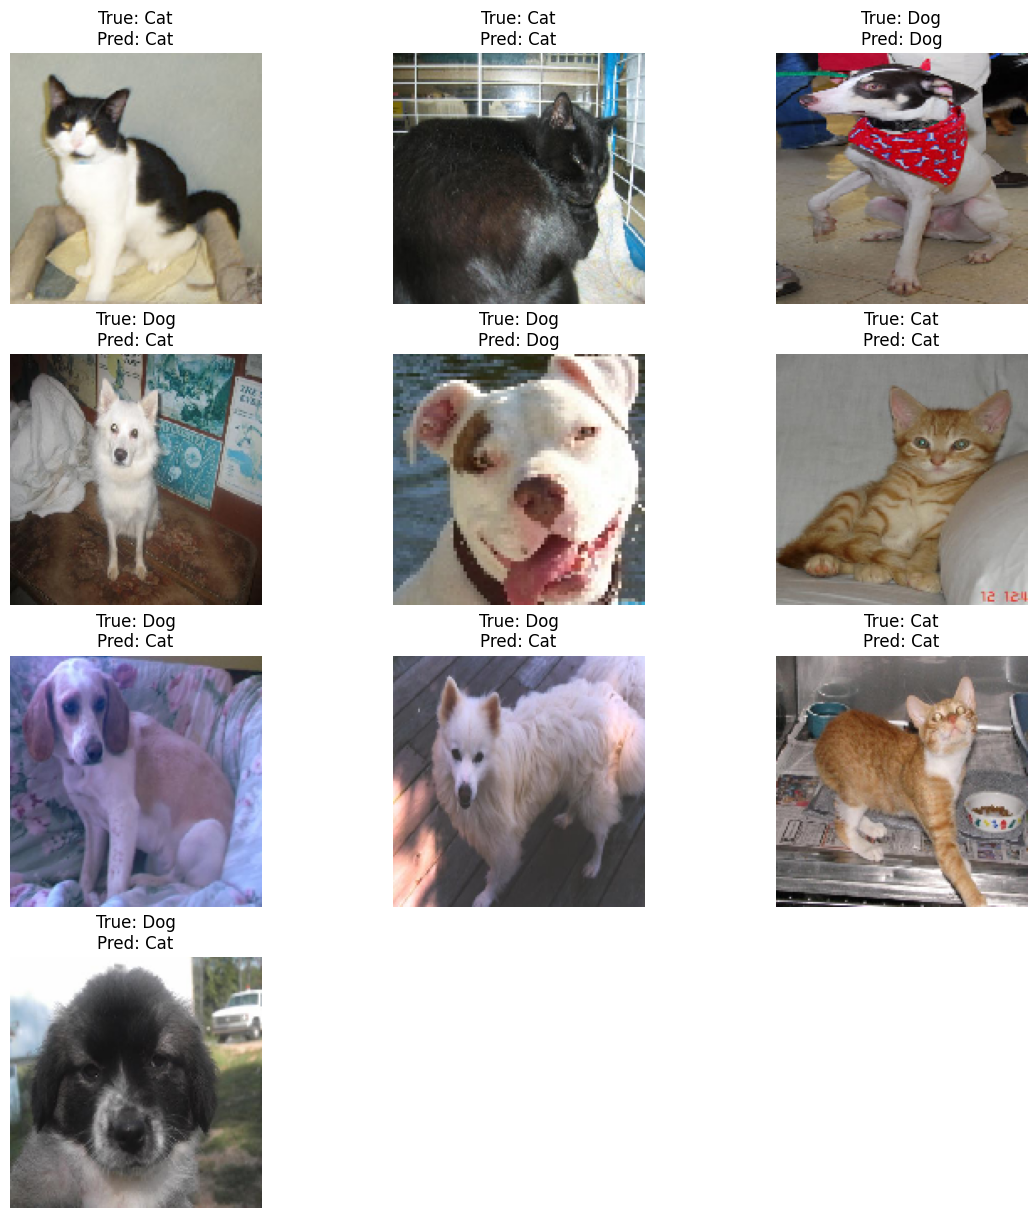

In [51]:
if INCLUDE_TEST:
    plot_prediction(test_generator, 10)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


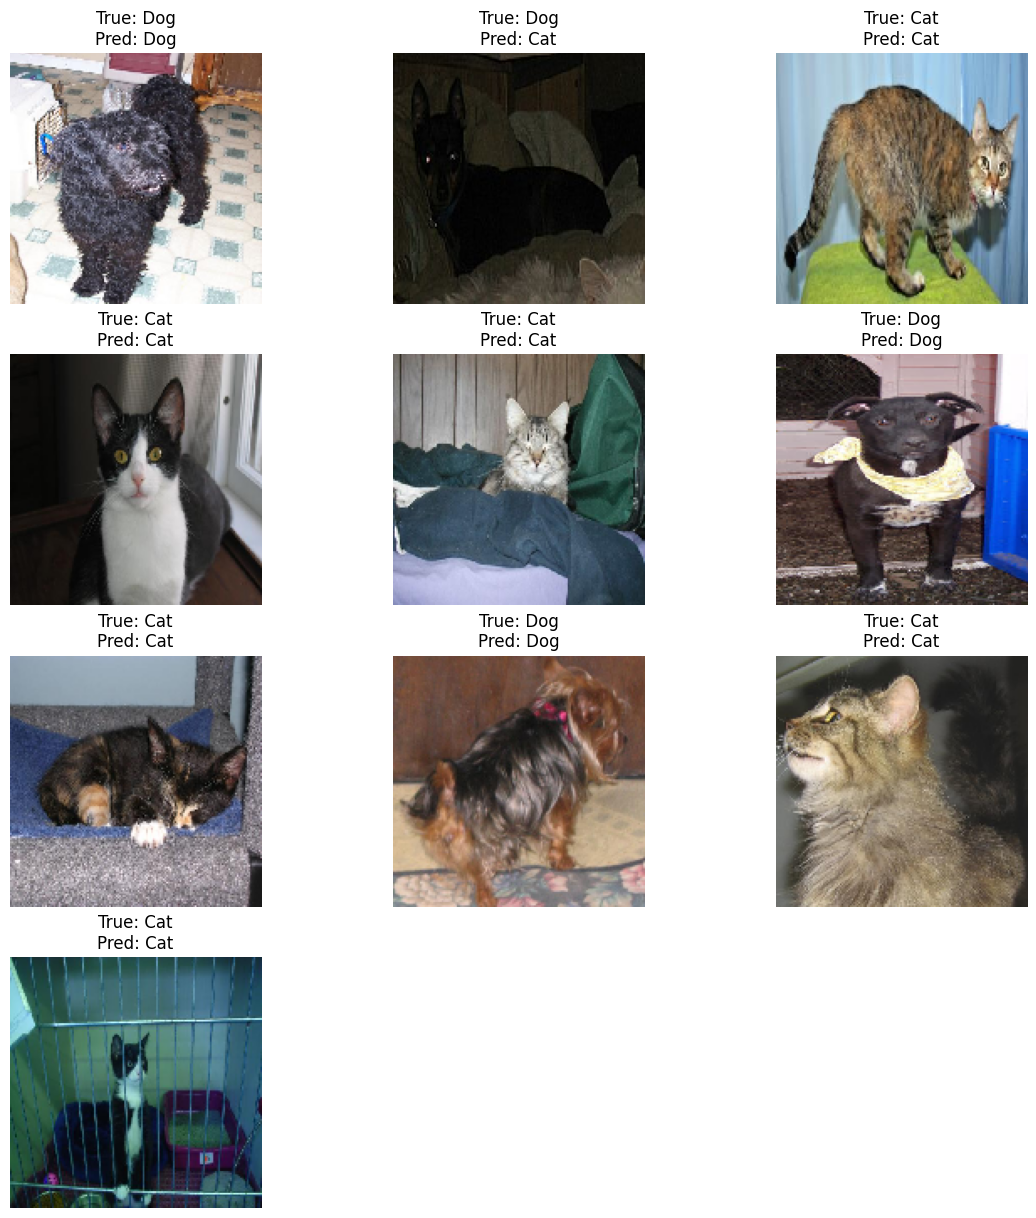

In [52]:
plot_prediction(validation_generator, 10)

#**Visualize Class Activation Maps**

In [55]:
from keras.models import Model

# Get the weights of the specific dense layer you are interested in
gp_weights = model.get_layer('dense_2').get_weights()[0]

# Create a model that will output the activation maps and the dense layer output
activation_model = Model(inputs=model.inputs, outputs=[model.get_layer('conv2d_10').output, model.get_layer('dense_3').output])

print("Model for activation map visualization created successfully.")


Model for activation map visualization created successfully.


In [57]:
# Use the model to make predictions on the test generator
images, _ = next(test_generator)  # Corrected the method to get the next batch
features, results = activation_model.predict(images)

print("Predictions made successfully.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
Predictions made successfully.


In [94]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def show_cam(image_index, features, results, model, images):
    """
    Displays the Class Activation Map (CAM) for a given image.
    Args:
    image_index: Index of the image in the batch.
    features: The feature maps from the convolutional layers.
    results: The predicted probabilities from the dense layer.
    model: The trained model to extract weights from.
    images: Original images to overlay CAM on.
    """
    # Get the feature map for the specific image
    class_activation_features = features[image_index]
    print(f"Feature map shape for image {image_index}: {class_activation_features.shape}")

    # Get the weights corresponding to the predicted class
    prediction = np.argmax(results[image_index])
    print(f"Predicted class for image {image_index}: {prediction}")

    # Extract weights from the dense layer (Ensure this layer name matches your model)
    dense_layer_weights = model.get_layer('dense_2').get_weights()[0]  # Replace 'dense_2' with your dense layer name
    print(f"Dense layer weights shape: {dense_layer_weights.shape}")

    # Get the weights for the predicted class
    class_activation_weights = dense_layer_weights[:, prediction]
    print(f"Class activation weights shape: {class_activation_weights.shape}")

    # Ensure the dimensions match
    if class_activation_features.shape[-1] != class_activation_weights.shape[0]:
        raise ValueError(f"Feature map channels ({class_activation_features.shape[-1]}) do not match weights ({class_activation_weights.shape[0]})")

    # Compute the CAM by performing a dot product and summing over channels
    cam_output = np.tensordot(class_activation_features, class_activation_weights, axes=(2, 0))
    print(f"CAM output shape: {cam_output.shape}")

    # Normalize CAM output
    cam_output = np.maximum(cam_output, 0)  # ReLU
    cam_output = cam_output / cam_output.max()  # Normalize

    # Resize CAM to match input image size
    cam_output = cv2.resize(cam_output, (images[image_index].shape[1], images[image_index].shape[0]))
    print(f"Resized CAM output shape: {cam_output.shape}")

    # Plot the original image and the CAM overlay
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images[image_index])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(images[image_index])
    plt.imshow(cam_output, cmap='jet', alpha=0.5)  # Overlay CAM on the image
    plt.axis('off')
    plt.show()



In [95]:
def show_maps(desired_class, num_maps, features, results, model, images):
    """
    Goes through the first 10,000 test images and generates CAM activation maps.
    Args:
    desired_class: Class to show the maps for.
    num_maps: Number of maps to be generated.
    features: The feature maps from the convolutional layers.
    results: The predicted probabilities from the dense layer.
    model: The trained model to extract weights from.
    images: Original images to overlay CAM on.
    """
    counter = 0
    # Go through the first 10,000 images
    for i in range(0, min(10000, len(results))):
        # Break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # Images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i, features, results, model, images)

# Example usage
# Ensure features, results, model, and images are defined and loaded correctly
# show_maps(desired_class=1, num_maps=5, features=features, results=results, model=model, images=images)


#**Visualize training process**

In [96]:
results = pd.DataFrame(r.history)
results.tail()

accuracy      loss  val_accuracy  val_loss
5  0.727107  0.545356      0.697904  0.569691
6  0.741830  0.527132      0.760789  0.495011
7  0.755865  0.506780      0.764077  0.485204
8  0.776452  0.478423      0.748048  0.503145
9  0.791134  0.454512      0.813810  0.417353

from matplotlib import pyplot as plt
_df_0['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['loss'].plot(kind='hist', bins=20, title='loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['val_accuracy'].plot(kind='hist', bins=20, title='val_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['val_loss'].plot(kind='hist', bins=20, title='val_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='accuracy', y='loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='loss', y='val_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='val_accuracy', y='val_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['accuracy']
  ys = series['loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['accuracy']
  ys = series['val_accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('val_accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['accuracy']
  ys = series['val_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('val_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'accuracy'}, axis=1)
              .sort_values('accuracy', ascending=True))
  xs = counted['accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['loss'].plot(kind='line', figsize=(8, 4), title='loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['val_accuracy'].plot(kind='line', figsize=(8, 4), title='val_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['val_loss'].plot(kind='line', figsize=(8, 4), title='val_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

In [97]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()

#**Trying Data Augmentation**

In [98]:
train_gen_aug = ImageDataGenerator(
        rescale=1./255,fill_mode='nearest',horizontal_flip=True,
        rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)


validation_gen_aug =  ImageDataGenerator(
        rescale=1./255.)


In [99]:
train_generator = train_gen_aug.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = validation_gen_aug.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 24724 images belonging to 2 classes.
Found 2433 images belonging to 2 classes.


In [100]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model_aug = Model(inputs=inputs, outputs=x)

In [101]:
model_aug.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [102]:
r = model_aug.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



206/773 ━━━━━━━━━━━━━━━━━━━━ 2:32 269ms/step - accuracy: 0.4972 - loss: 0.7234

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning:

Truncated File Read



773/773 ━━━━━━━━━━━━━━━━━━━━ 229s 276ms/step - accuracy: 0.5020 - loss: 0.7041 - val_accuracy: 0.5290 - val_loss: 0.7197
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 246s 271ms/step - accuracy: 0.5805 - loss: 0.6706 - val_accuracy: 0.6987 - val_loss: 0.5670
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 262s 271ms/step - accuracy: 0.6662 - loss: 0.6101 - val_accuracy: 0.6753 - val_loss: 0.6098
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 214s 273ms/step - accuracy: 0.6996 - loss: 0.5715 - val_accuracy: 0.6860 - val_loss: 0.6300
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 257s 269ms/step - accuracy: 0.7318 - loss: 0.5369 - val_accuracy: 0.7789 - val_loss: 0.4708
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 268s 275ms/step - accuracy: 0.7646 - loss: 0.4972 - val_accuracy: 0.8113 - val_loss: 0.4396
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 210s 270ms/step - accuracy: 0.7931 - loss: 0.4523 - val_accuracy: 0.8516 - val_loss: 0.3400
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 263s 270ms/step - accuracy: 0.8217 - loss: 0.40

In [103]:
results = pd.DataFrame(r.history)
results.tail()

accuracy      loss  val_accuracy  val_loss
5  0.771801  0.487745      0.811344  0.439643
6  0.797039  0.447971      0.851624  0.339979
7  0.823613  0.402437      0.880395  0.280206
8  0.845777  0.358614      0.889848  0.254673
9  0.854312  0.340050      0.909577  0.225895

In [104]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [105]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()